In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import joblib
import os
import re
import json
from tqdm import tqdm_notebook
import gensim
import pymorphy2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [3]:
DIR_PATH = '/Users/anton.andreytsev/Desktop/Avito_catagory_classification/'

Загрузка данных

In [46]:
dat = pd.read_csv(os.path.join(DIR_PATH, 'avito_train.csv'))
cat_descr = pd.read_csv(os.path.join(DIR_PATH, 'avito_category.csv'))
dat['category_name'] = dat.category_id.map(dict(zip(cat_descr.category_id, cat_descr.name)))

In [47]:
dat.head()

,item_id,title,description,price,category_id,category_name
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19,Для дома и дачи|Мебель и интерьер|Предметы инт...
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22,Для дома и дачи|Мебель и интерьер|Столы и стулья
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37,Личные вещи|Красота и здоровье|Приборы и аксес...
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43,Хобби и отдых|Книги и журналы|Книги
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1,Бытовая электроника|Ноутбуки


### Подготовка данных

In [48]:
# tr_indexes, valid_indexes, te_indexes = np.split(np.arange(dat.shape[0]), [int(np.floor(0.6*dat.shape[0])), int(np.floor(0.6*dat.shape[0])) + 
#                           int(np.floor(0.3*dat.shape[0]))])
# np.save(os.path.join(DIR_PATH, 'train_indexes.npy'), tr_indexes)
# np.save(os.path.join(DIR_PATH, 'valid_indexes.npy'), valid_indexes)
# np.save(os.path.join(DIR_PATH, 'test_indexes.npy'), te_indexes)
tr_indexes = np.load(os.path.join(DIR_PATH, 'train_indexes.npy'))
valid_indexes = np.load(os.path.join(DIR_PATH, 'valid_indexes.npy'))
te_indexes = np.load(os.path.join(DIR_PATH, 'test_indexes.npy'))

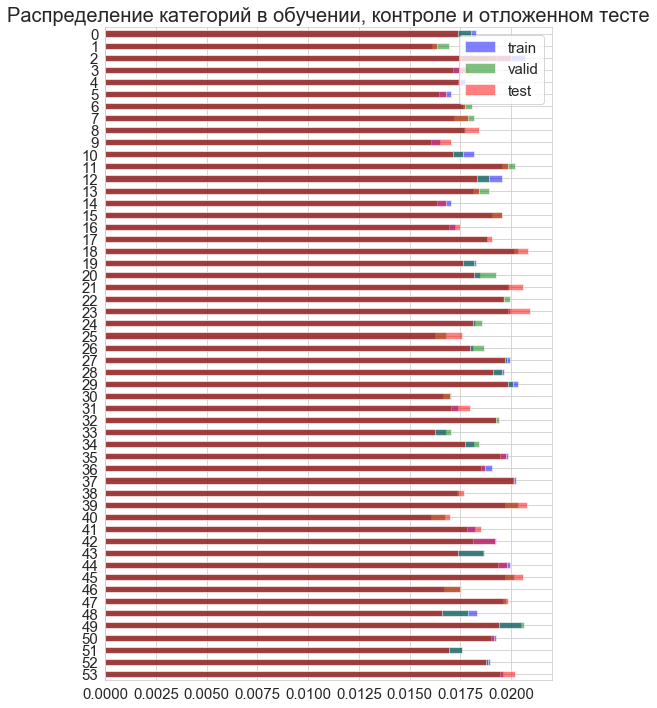

In [49]:
plt.figure(figsize=(8, 12))
plt.title('Распределение категорий в обучении, контроле и отложенном тесте', fontsize=20);
dat.category_id[tr_indexes].value_counts(1).sort_index(ascending=False).plot(kind='barh', fontsize=15, color='blue', alpha=0.5, label='train');
dat.category_id[valid_indexes].value_counts(1).sort_index(ascending=False).plot(kind='barh', fontsize=15, color='green', alpha=0.5, label='valid');
dat.category_id[te_indexes].value_counts(1).sort_index(ascending=False).plot(kind='barh', fontsize=15, color='red', alpha=0.5, label='test');
plt.legend(fontsize=15);

Разобьём таргет на иерархические классы

In [50]:
# Длина самое длинной цепочти таргета
max_hierarchy_len = np.unique([len(cat_list.split('|')) for cat_list in dat.category_name.values])[-1]
dat['category_1'] = None
dat['category_2'] = None
dat['category_3'] = None
dat['category_4'] = None
splitted_categories = []
for i in tqdm_notebook(range(dat.shape[0])):
    split_categories = dat.category_name[i].split('|')
    splitted_categories.append(split_categories + [None for j in range(max_hierarchy_len - len(split_categories))])
dat[['category_1', 'category_2', 'category_3', 'category_4']] = splitted_categories
del splitted_categories

Посмотрим на распределение меток по уровням в обучении, контроле и отложенном тесте

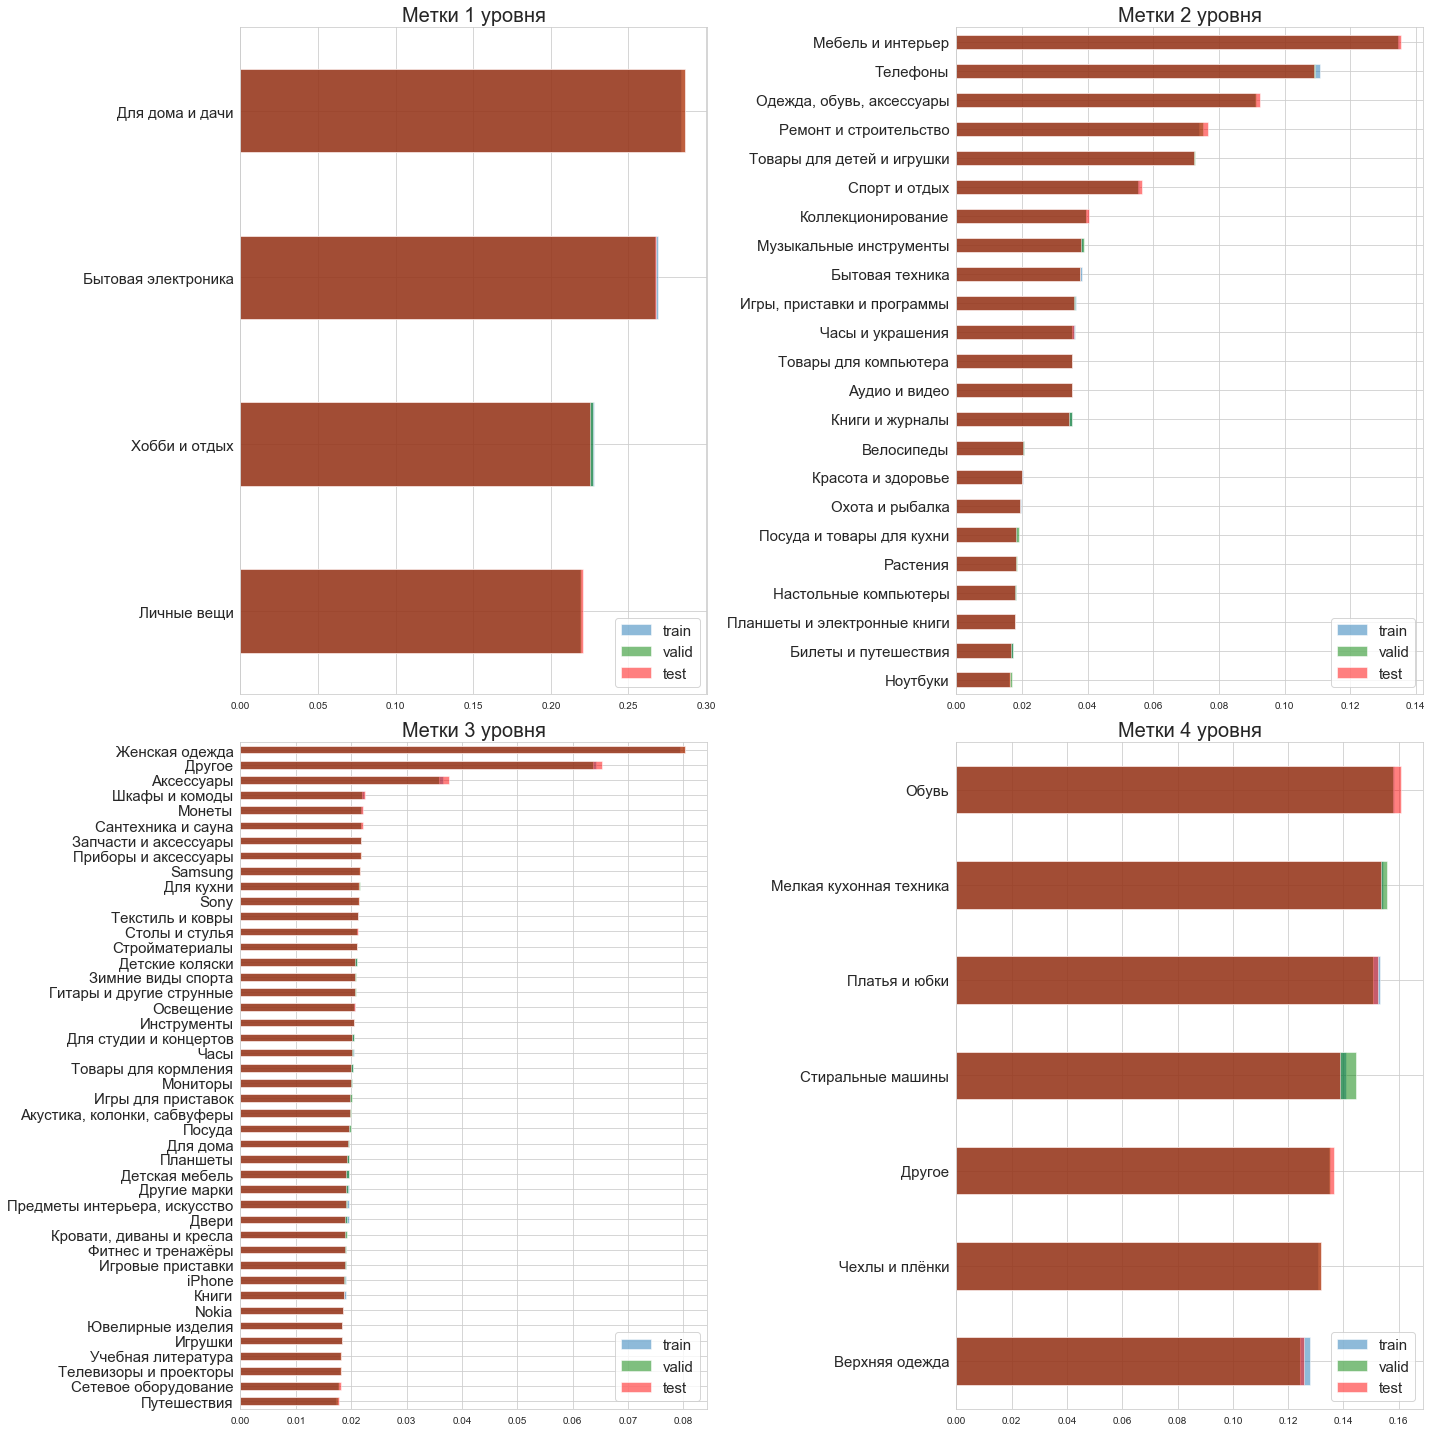

In [52]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
k = 1
for (i, j) in itertools.product(range(2), range(2)):
    dat['category_{}'.format(k)][tr_indexes].value_counts(1).sort_values(ascending=True).plot(kind='barh', alpha=0.5, label='train', 
                                                                                              ax=ax[i, j])
    dat['category_{}'.format(k)][valid_indexes].value_counts(1).sort_values(ascending=True).plot(kind='barh', color='green', alpha=0.5, 
                                                                                                 label='valid', ax=ax[i, j])
    dat['category_{}'.format(k)][te_indexes].value_counts(1).sort_values(ascending=True).plot(kind='barh', color='red', alpha=0.5, 
                                                                                              label='test', ax=ax[i, j])
    plt.sca(ax[i, j])
    plt.yticks(fontsize=15);
    plt.legend(fontsize=15);
    plt.title('Метки {} уровня'.format(k), fontsize=20);
    fig.tight_layout();
    k += 1

Загрузим список стоп-слов https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.json

In [136]:
morph = pymorphy2.MorphAnalyzer()

In [345]:
stop_words_set = set(json.load(open(os.path.join(DIR_PATH, 'stopwords-ru.json'), mode='r', encoding='utf-8')))
stop_words_lemm_set = set()
for word in stop_words_set:
    lemm_word = morph.parse(word)[0].normal_form
    if lemm_word not in stop_words_lemm_set:
        stop_words_lemm_set = stop_words_lemm_set.union([lemm_word])
stop_words_lemm_set = stop_words_lemm_set.union(['продать', "купить", "скидка", "выгодно", "предложение", "подробность", "телефон", 
                                                 "недорого", 'состояние', 'размер', "рубль", "отличный", "сантиметр", "цена", 
                                                "комплект", "мм", "см", "продавать", "торг", "доставка", "цвета", "звонить", "вес", 
                                                 "товар"])

Пример стоп-слов

In [346]:
print(list(stop_words_lemm_set)[:12])

['главный', 'ещё', 'где', 'большой', 'скидка', 'есть', 'недавно', 'семнадцать', 'затем', 'посмотреть', 'не', 'вообще']


Лемматизируем тексты

In [347]:
dat['title_processed'] = None
dat['description_processed'] = None
title_processed_list = []
regexp_pattern = r'[_,.!><?"@#$%^&*\t():»«+-0123456789]'
for i in tqdm_notebook(range(len(dat))):
    sentence = re.sub(regexp_pattern, ' ', dat.title[i].lower()).split()
    current_sentense = ''
    for word in sentence:
        lemm_word = morph.parse(word)[0].normal_form
        if lemm_word not in stop_words_lemm_set:
            current_sentense += ' ' + lemm_word
    title_processed_list.append(current_sentense.strip())
dat.title_processed = title_processed_list
del title_processed_list

description_processed_list = []
for i in tqdm_notebook(range(len(dat))):
    # убираем знаки препинания и пунктуацию
    sentence = re.sub(regexp_pattern, ' ', dat.description[i].lower()).split()
    current_sentense = ''
    for word in sentence:
        lemm_word = morph.parse(word)[0].normal_form
        if lemm_word not in stop_words_lemm_set:
            current_sentense += ' ' + lemm_word
    description_processed_list.append(current_sentense.strip())
dat.description_processed = description_processed_list
del description_processed_list


KeyboardInterrupt: 

In [337]:
# %%time
# from sklearn.feature_extraction.text import TfidfVectorizer
# tf_idf = TfidfVectorizer()
# tf_idf.fit(dat.description_processed)

Wall time: 29.1 s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [338]:
word_idf_dict = dict(zip(tf_idf.get_feature_names(), tf_idf.idf_))

In [342]:
word_idf_dict = dict(sorted(word_idf_dict.items(), key=lambda x: x[1], reverse=True))

Загружаем предобученный w2v на русской википедии https://nlpub.mipt.ru/Russian_Distributional_Thesaurus

In [4]:
%%time
w2v_fpath = "/Users/anton.andreytsev/Downloads/tenth.norm-sz500-w7-cb0--min5.w2v"
w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_fpath, binary=True, unicode_errors='ignore')
w2v.init_sims(replace=True)

Wall time: 3min


In [77]:
dat

,item_id,title,description,price,category_id,category_name,category_1,category_2,category_3,category_4
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19,Для дома и дачи|Мебель и интерьер|Предметы инт...,Для дома и дачи,Мебель и интерьер,"Предметы интерьера, искусство",None
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22,Для дома и дачи|Мебель и интерьер|Столы и стулья,Для дома и дачи,Мебель и интерьер,Столы и стулья,None
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37,Личные вещи|Красота и здоровье|Приборы и аксес...,Личные вещи,Красота и здоровье,Приборы и аксессуары,None
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43,Хобби и отдых|Книги и журналы|Книги,Хобби и отдых,Книги и журналы,Книги,None
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1,Бытовая электроника|Ноутбуки,Бытовая электроника,Ноутбуки,None,None
5,5,Бас гитара invasion bg110,Состояние хорошее. Имеется теплый чехол .,3999.0,50,Хобби и отдых|Музыкальные инструменты|Гитары и...,Хобби и отдых,Музыкальные инструменты,Гитары и другие струнные,None
6,6,"Смесь ""Грудничок"" г. Зеленодольск",Смесь молочная адаптированная ультрапастеризов...,15.0,41,Личные вещи|Товары для детей и игрушки|Товары ...,Личные вещи,Товары для детей и игрушки,Товары для кормления,None
7,7,G-shock,Часы абсолютно новые! с коробкой. Часы Китай...,2500.0,36,Личные вещи|Часы и украшения|Часы,Личные вещи,Часы и украшения,Часы,None
8,8,"Санатории Белоруссии. - ""Лепельский военный""",Санатории Белоруссии! - «Лепельский военный» ...,1090.0,48,Хобби и отдых|Билеты и путешествия|Путешествия,Хобби и отдых,Билеты и путешествия,Путешествия,None
9,9,Фотохолст,Фотохолст на подрамнике. 36х58см. Галерейная н...,1250.0,19,Для дома и дачи|Мебель и интерьер|Предметы инт...,Для дома и дачи,Мебель и интерьер,"Предметы интерьера, искусство",None
